In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

torch.Size([60000, 28, 28])

torch.Size([60000])

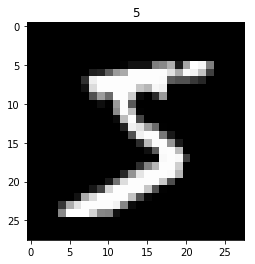

In [2]:
# Hyper Parameters
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = False

train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)

# plot one example
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [3]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_data = torchvision.datasets.MNIST(root='./mnist', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)[:2000] / 255
test_y = test_data.test_labels[:2000]

D:\python\python 3.5\lib\site-packages\ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 展平操作
        output = self.out(x)
        return output,x


cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [19]:
optimizer = torch.optim.Adam(cnn.parameters(),lr=LR)
loss_func = nn.CrossEntropyLoss()

In [20]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm

try:
    from sklearn.manifold import TSNE
    HAS_SK = True
except:
    HAS_SK = False
    print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title('Visualize last layer')
    plt.show()
    plt.pause(0.01)

plt.ion()

Epoch: 

0

| train loss: 2.3047

| test accuracy: 0.23

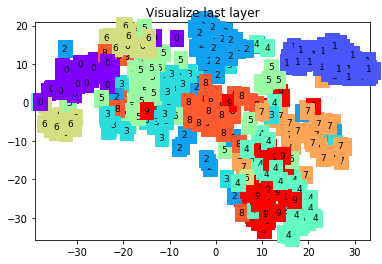

Epoch: 

0

| train loss: 0.8231

| test accuracy: 0.80

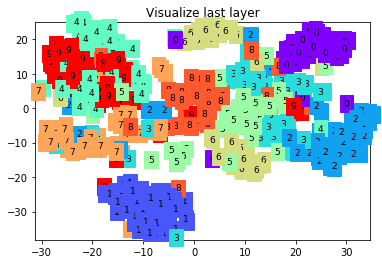

Epoch: 

0

| train loss: 0.5239

| test accuracy: 0.88

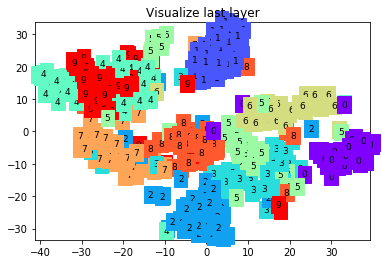

Epoch: 

0

| train loss: 0.2138

| test accuracy: 0.91

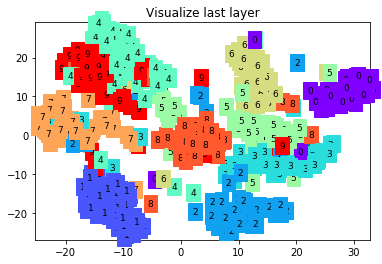

Epoch: 

0

| train loss: 0.1745

| test accuracy: 0.91

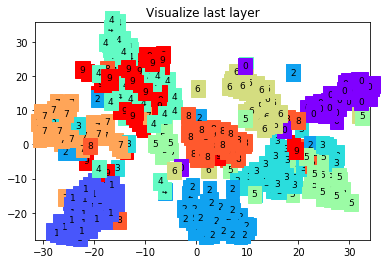

Epoch: 

0

| train loss: 0.0671

| test accuracy: 0.92

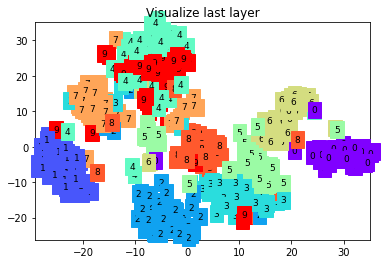

Epoch: 

0

| train loss: 0.0971

| test accuracy: 0.95

In [21]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):  # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]  # cnn output
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')